In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
import seaborn as sns

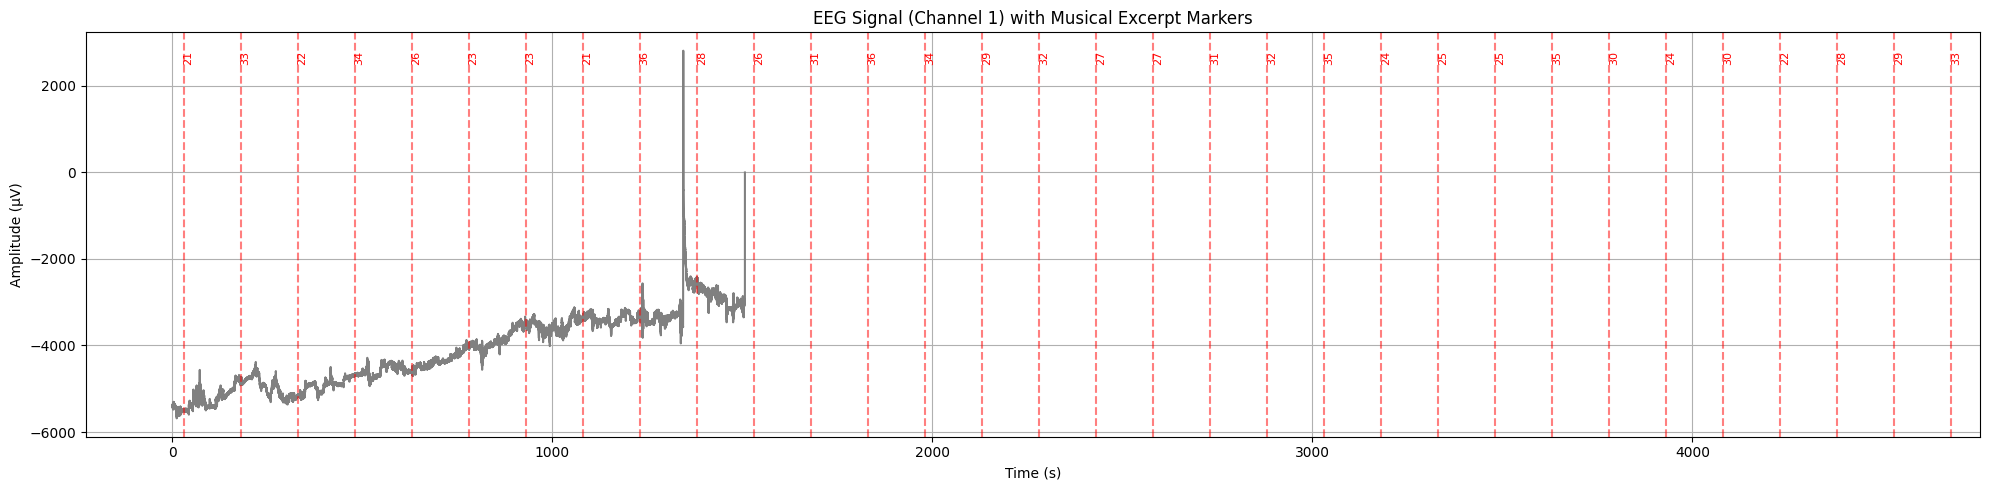

In [2]:
# Load EEG Channel 1 only
file_path_1 = r"C:\Users\Krishnansh Verma\OneDrive\Desktop\Python and ML\Projects\CAPSTONE\Capstone Dataset\X.mat"
X = scipy.io.loadmat(file_path_1, simplify_cells=True)['X']  # Shape: (129, N)
eeg_channel = X[0]  # Channel 1 (index 0)

# Load sampling frequency
file_path_2 = r"C:\Users\Krishnansh Verma\OneDrive\Desktop\Python and ML\Projects\CAPSTONE\Capstone Dataset\Fs.mat"
Fs = int(scipy.io.loadmat(file_path_2, simplify_cells=True)['Fs'])

# Load TCP triggers
file_path_3 = r"C:\Users\Krishnansh Verma\OneDrive\Desktop\Python and ML\Projects\CAPSTONE\Capstone Dataset\Triggers.TCP.mat"
tcp_data = scipy.io.loadmat(file_path_3, struct_as_record=False, squeeze_me=True)['Triggers'].TCP

# Time axis
time_axis = np.arange(len(eeg_channel)) / Fs

# Detect excerpt markers
excerpt_start_times = []
excerpt_codes = []

for i in range(len(tcp_data) - 1):
    try:
        if int(tcp_data[i]) == 11 and 21 <= int(tcp_data[i + 1]) <= 36:
            excerpt_codes.append(int(tcp_data[i + 1]))
            excerpt_start_times.append(i * 30)  # assuming each trial ≈ 30s
    except:
        continue

# Plot Channel 1 with markers
plt.figure(figsize=(20, 5))
plt.plot(time_axis, eeg_channel, label="EEG Channel 1", color='gray')

# Add excerpt markers
for i, t in enumerate(excerpt_start_times):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.5)
    plt.text(t, max(eeg_channel) * 0.9, f"{excerpt_codes[i]}", rotation=90, fontsize=8, color='red')

plt.title("EEG Signal (Channel 1) with Musical Excerpt Markers")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [3]:
mat = scipy.io.loadmat(file_path_3, struct_as_record=False, squeeze_me=True)
tcp_data = mat['Triggers'].TCP

print("Total trigger markers in block:", len(tcp_data))
print("First 10 trigger values:", tcp_data[:10])

excerpt_codes = []

for i in range(len(tcp_data) - 1):
    current = tcp_data[i]
    next_val = tcp_data[i + 1]

    try:
        if int(current) == 11:
            excerpt = int(next_val)
            # Only include if it's in known range of music excerpts
            if 21 <= excerpt <= 36:
                excerpt_codes.append(excerpt)
    except (ValueError, TypeError):
        continue

unique_excerpts = sorted(set(excerpt_codes))

# Output
if unique_excerpts:
    print("\n🎵 Valid unique musical excerpt codes in this block (following marker 11):")
    for code in unique_excerpts:
        print(f"- Excerpt Code: {code}")
else:
    print("❗ No valid excerpt codes found.")

print(f"\n✅ Total unique musical excerpts: {len(unique_excerpts)}")


Total trigger markers in block: 161
First 10 trigger values: [11 11 21  6  5  8 11 33  7  8]

🎵 Valid unique musical excerpt codes in this block (following marker 11):
- Excerpt Code: 21
- Excerpt Code: 22
- Excerpt Code: 23
- Excerpt Code: 24
- Excerpt Code: 25
- Excerpt Code: 26
- Excerpt Code: 27
- Excerpt Code: 28
- Excerpt Code: 29
- Excerpt Code: 30
- Excerpt Code: 31
- Excerpt Code: 32
- Excerpt Code: 33
- Excerpt Code: 34
- Excerpt Code: 35
- Excerpt Code: 36

✅ Total unique musical excerpts: 16


In [4]:
# Load data
# X = scipy.io.loadmat("X.mat", simplify_cells=True)['X']          # EEG: [129, samples]
# Fs = int(scipy.io.loadmat("Fs.mat", simplify_cells=True)['Fs'])  # Sampling rate
# tcp_data = scipy.io.loadmat("Triggers.TCP.mat", struct_as_record=False, squeeze_me=True)['Triggers'].TCP

# Constants
excerpt_duration_sec = 30
excerpt_duration_samples = Fs * excerpt_duration_sec
output_folder = "segments_by_excerpt"
os.makedirs(output_folder, exist_ok=True)

# Segment EEG based on trigger markers
excerpt_segments = {}

for i in range(len(tcp_data) - 1):
    current = tcp_data[i]
    next_val = tcp_data[i + 1]

    try:
        if int(current) == 11 and 21 <= int(next_val) <= 36:
            excerpt_code = int(next_val)
            start_sample = i * excerpt_duration_samples
            end_sample = start_sample + excerpt_duration_samples

            if end_sample <= X.shape[1]:
                segment = X[:, start_sample:end_sample]

                # Store
                if excerpt_code not in excerpt_segments:
                    excerpt_segments[excerpt_code] = []
                excerpt_segments[excerpt_code].append(segment)

                # Save
                filename = f"{output_folder}/excerpt_{excerpt_code}_trial_{len(excerpt_segments[excerpt_code])}.npy"
                np.save(filename, segment)
                print(f"Saved segment: {filename}")

                # Plot first channel of EEG segment
                time_axis = np.arange(0, excerpt_duration_samples) / Fs
                plt.figure(figsize=(10, 3))
                plt.plot(time_axis, segment[0], color='steelblue')  # Channel 1
                plt.title(f"Excerpt {excerpt_code} – Trial {len(excerpt_segments[excerpt_code])} (Channel 1)")
                plt.xlabel("Time (s)")
                plt.ylabel("EEG Amplitude (µV)")
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"{output_folder}/excerpt_{excerpt_code}_trial_{len(excerpt_segments[excerpt_code])}.png")
                plt.close()

    except Exception as e:
        print(f"Skipped trigger at index {i}: {e}")

print("\n✅ Segmentation and plots completed.")

Saved segment: segments_by_excerpt/excerpt_21_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_33_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_22_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_34_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_26_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_23_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_23_trial_2.npy
Saved segment: segments_by_excerpt/excerpt_21_trial_2.npy
Saved segment: segments_by_excerpt/excerpt_36_trial_1.npy
Saved segment: segments_by_excerpt/excerpt_28_trial_1.npy

✅ Segmentation and plots completed.


In [5]:
# Path where EEG segments are saved
segment_folder = "segments_by_excerpt"

# List all .npy files (segmented EEG)
segment_files = sorted([f for f in os.listdir(segment_folder) if f.endswith('.npy')])

# Loop through and print numerical data
for file in segment_files:
    file_path = os.path.join(segment_folder, file)
    eeg_segment = np.load(file_path)  # Shape: [129, 30000]

    print(f"\n📄 File: {file}")
    print(f"Shape: {eeg_segment.shape} (Channels × Samples)")

    # Print numerical EEG values (sampled portion for readability)
    print("EEG data (first 5 channels × first 10 samples):\n")
    print(eeg_segment[:5, :10])  # First 5 channels, first 10 time points

    # Optional: pause between prints or break early
    input("Press Enter to continue...\n")


📄 File: excerpt_21_trial_1.npy
Shape: (129, 30000) (Channels × Samples)
EEG data (first 5 channels × first 10 samples):

[[ -5513.762   -5510.187   -5504.9707  -5503.6724  -5497.3223  -5499.516
   -5497.177   -5497.7803  -5500.0547  -5497.92  ]
 [-13598.079  -13603.783  -13598.684  -13595.609  -13596.326  -13595.392
  -13593.821  -13587.722  -13588.694  -13590.197 ]
 [-12286.043  -12294.243  -12295.134  -12292.781  -12293.057  -12295.797
  -12296.89   -12294.379  -12295.999  -12293.967 ]
 [ -3031.115   -3037.0574  -3033.9998  -3033.4878  -3036.4148  -3036.7944
   -3036.2378  -3030.6682  -3032.7102  -3035.5671]
 [ -1293.1993  -1294.9918  -1294.0232  -1292.9443  -1294.3738  -1296.8059
   -1297.3542  -1295.009   -1293.9476  -1295.1605]]

📄 File: excerpt_21_trial_2.npy
Shape: (129, 30000) (Channels × Samples)
EEG data (first 5 channels × first 10 samples):

[[ -3401.5608   -3398.8083   -3397.6086   -3399.2178   -3396.5493
   -3394.7024   -3395.08     -3397.5837   -3395.7058   -3398.6978 ]

In [6]:
# Simulated list of 129 channel names (replace with real ones if available)
channel_names = [f"Ch{i+1}" for i in range(129)]

# Path to segmented .npy EEG files
segment_folder = "segments_by_excerpt"
output_folder = "selected_64_channels"
os.makedirs(output_folder, exist_ok=True)

# Loop over all segments
for file in sorted(os.listdir(segment_folder)):
    if file.endswith(".npy"):
        file_path = os.path.join(segment_folder, file)
        eeg = np.load(file_path)  # Shape: (129, 30000)

        # Step 1: Calculate variance of each channel
        channel_variances = np.var(eeg, axis=1)

        # Step 2: Get indices of top 64 channels
        top_64_indices = np.argsort(channel_variances)[-64:]
        top_64_indices = np.sort(top_64_indices)

        # Step 3: Get corresponding channel names
        top_64_names = [channel_names[i] for i in top_64_indices]

        # Step 4: Extract reduced EEG
        reduced_eeg = eeg[top_64_indices, :]

        # Step 5: Save reduced EEG
        out_path = os.path.join(output_folder, file.replace(".npy", "_64ch.npy"))
        np.save(out_path, reduced_eeg)

        # Step 6: Print details
        print(f"\n✅ Saved: {os.path.basename(out_path)}")
        print(f"   Shape: {reduced_eeg.shape} (Channels × Samples)")
        print(f"   Selected Channel Indices: {top_64_indices.tolist()}")
        print(f"   Selected Channel Names:   {top_64_names}")



✅ Saved: excerpt_21_trial_1_64ch.npy
   Shape: (64, 30000) (Channels × Samples)
   Selected Channel Indices: [0, 1, 7, 8, 13, 14, 15, 16, 20, 21, 22, 24, 26, 28, 31, 32, 33, 37, 38, 39, 42, 43, 44, 45, 47, 48, 49, 50, 55, 56, 57, 62, 63, 64, 65, 67, 68, 72, 73, 80, 81, 82, 87, 88, 89, 90, 93, 98, 99, 106, 107, 108, 112, 113, 114, 115, 118, 119, 120, 121, 124, 125, 126, 127]
   Selected Channel Names:   ['Ch1', 'Ch2', 'Ch8', 'Ch9', 'Ch14', 'Ch15', 'Ch16', 'Ch17', 'Ch21', 'Ch22', 'Ch23', 'Ch25', 'Ch27', 'Ch29', 'Ch32', 'Ch33', 'Ch34', 'Ch38', 'Ch39', 'Ch40', 'Ch43', 'Ch44', 'Ch45', 'Ch46', 'Ch48', 'Ch49', 'Ch50', 'Ch51', 'Ch56', 'Ch57', 'Ch58', 'Ch63', 'Ch64', 'Ch65', 'Ch66', 'Ch68', 'Ch69', 'Ch73', 'Ch74', 'Ch81', 'Ch82', 'Ch83', 'Ch88', 'Ch89', 'Ch90', 'Ch91', 'Ch94', 'Ch99', 'Ch100', 'Ch107', 'Ch108', 'Ch109', 'Ch113', 'Ch114', 'Ch115', 'Ch116', 'Ch119', 'Ch120', 'Ch121', 'Ch122', 'Ch125', 'Ch126', 'Ch127', 'Ch128']

✅ Saved: excerpt_21_trial_2_64ch.npy
   Shape: (64, 30000) (Channel

In [7]:
# Simulated channel names — replace with actual if available
channel_names = [f"Ch{i+1}" for i in range(129)]

# Folder paths
segment_folder = "segments_by_excerpt"
output_folder = "selected_common64_channels"
os.makedirs(output_folder, exist_ok=True)

# Step 1: Accumulate variances across all segments
all_variances = []

print("📊 Calculating variance for all segments...")

for file in sorted(os.listdir(segment_folder)):
    if file.endswith(".npy"):
        file_path = os.path.join(segment_folder, file)
        eeg = np.load(file_path)  # Shape: (129, 30000)

        variances = np.var(eeg, axis=1)  # Per-channel variance
        all_variances.append(variances)

# Step 2: Compute average variance across all segments
mean_variance = np.mean(all_variances, axis=0)  # Shape: (129,)

# Step 3: Select common top 64 channels
top_64_indices = np.argsort(mean_variance)[-64:]
top_64_indices = np.sort(top_64_indices)
top_64_names = [channel_names[i] for i in top_64_indices]

print("\n✅ Common Best 64 Channels Selected Across All Segments:")
print(f"Indices: {top_64_indices.tolist()}")
print(f"Names:   {top_64_names}")

# Step 4: Apply selection to all segments and save
print("\n💾 Saving all segments with selected 64 channels...")

for file in sorted(os.listdir(segment_folder)):
    if file.endswith(".npy"):
        file_path = os.path.join(segment_folder, file)
        eeg = np.load(file_path)

        reduced_eeg = eeg[top_64_indices, :]
        out_path = os.path.join(output_folder, file.replace(".npy", "_64ch.npy"))
        np.save(out_path, reduced_eeg)
        print(f"Saved: {os.path.basename(out_path)}")

print("\n🎉 Done! All segments saved with common top 64 channels.")

📊 Calculating variance for all segments...

✅ Common Best 64 Channels Selected Across All Segments:
Indices: [0, 1, 2, 7, 8, 13, 14, 15, 16, 20, 21, 22, 24, 25, 26, 31, 32, 33, 37, 38, 42, 43, 44, 45, 47, 48, 49, 55, 56, 57, 62, 63, 64, 65, 67, 68, 72, 73, 74, 80, 81, 87, 88, 92, 93, 94, 98, 99, 106, 107, 108, 112, 113, 114, 115, 118, 119, 120, 121, 122, 124, 125, 126, 127]
Names:   ['Ch1', 'Ch2', 'Ch3', 'Ch8', 'Ch9', 'Ch14', 'Ch15', 'Ch16', 'Ch17', 'Ch21', 'Ch22', 'Ch23', 'Ch25', 'Ch26', 'Ch27', 'Ch32', 'Ch33', 'Ch34', 'Ch38', 'Ch39', 'Ch43', 'Ch44', 'Ch45', 'Ch46', 'Ch48', 'Ch49', 'Ch50', 'Ch56', 'Ch57', 'Ch58', 'Ch63', 'Ch64', 'Ch65', 'Ch66', 'Ch68', 'Ch69', 'Ch73', 'Ch74', 'Ch75', 'Ch81', 'Ch82', 'Ch88', 'Ch89', 'Ch93', 'Ch94', 'Ch95', 'Ch99', 'Ch100', 'Ch107', 'Ch108', 'Ch109', 'Ch113', 'Ch114', 'Ch115', 'Ch116', 'Ch119', 'Ch120', 'Ch121', 'Ch122', 'Ch123', 'Ch125', 'Ch126', 'Ch127', 'Ch128']

💾 Saving all segments with selected 64 channels...
Saved: excerpt_21_trial_1_64ch.npy
Sa

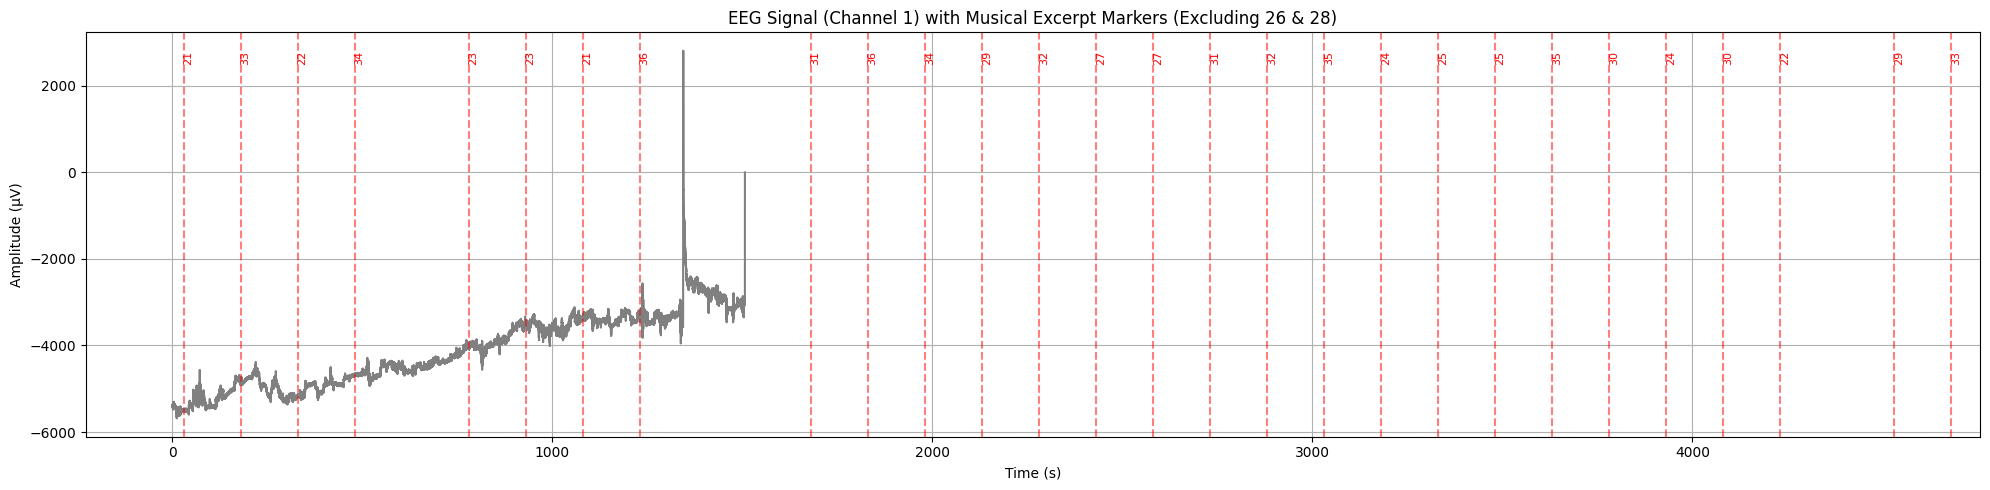

In [8]:
# Use channel 1 (index 0) for plotting
eeg_channel = X[0]  # 1D array of EEG signal

# Calculate time axis in seconds
time_axis = np.arange(len(eeg_channel)) / Fs

# Estimate start points of excerpts
excerpt_start_times = []
excerpt_codes = []

for i in range(len(tcp_data) - 1):
    current = tcp_data[i]
    next_val = tcp_data[i + 1]

    try:
        if int(current) == 11 and 21 <= int(next_val) <= 36:
            code = int(next_val)
            if code not in [26, 28]:  # 🚫 Exclude excerpts 26 and 28
                excerpt_codes.append(code)
                start_time = i * 30  # assuming each trial ≈ 30s
                excerpt_start_times.append(start_time)
    except:
        continue

# Plot
plt.figure(figsize=(20, 5))
plt.plot(time_axis, eeg_channel, label="EEG Channel 1", color='gray')

# Add vertical lines for excerpt start markers (excluding removed ones)
for i, t in enumerate(excerpt_start_times):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.5)
    plt.text(t, max(eeg_channel)*0.9, f"{excerpt_codes[i]}", rotation=90, fontsize=8, color='red')

plt.title("EEG Signal (Channel 1) with Musical Excerpt Markers (Excluding 26 & 28)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
def print_excerpts_summary(segment_dict, removed_excerpts=None):
    """
    Standard reusable function to report excerpt status after manual threshold removal.

    Parameters:
    - segment_dict: dict with excerpt_code as keys (e.g., excerpt_segments)
    - removed_excerpts: list of codes to manually exclude (default: [])

    Returns:
    - remaining_excerpts: sorted list of excerpt codes after removal
    """
    # Step 1: Extract all excerpt codes present
    original_excerpts = sorted(list(segment_dict.keys()))

    # Step 2: Handle default argument
    if removed_excerpts is None:
        removed_excerpts = []

    # Step 3: Filter remaining excerpts
    remaining_excerpts = [code for code in original_excerpts if code not in removed_excerpts]

    # Step 4: Print clean summary
    print("🎼 Original Musical Excerpts Detected:", original_excerpts)
    print("❌ Manually Removed Excerpts:", removed_excerpts if removed_excerpts else "None")
    print("✅ Remaining Excerpts After Removal:", remaining_excerpts)
    print("📊 Remaining Count:", len(remaining_excerpts))

    return remaining_excerpts


⏳ Analyzing EEG amplitude distribution...
📊 Data distribution analysis:
  - Median amplitude: -8386.18 µV
  - MAD: 3694.48 µV
  - Q1/Q3: 4767.11/12167.88 µV
  - Selected amplitude threshold: 21568.24 µV
  - Percent threshold: 10.00%

⏳ Applying threshold epoch selection...
✅ Kept: excerpt_21_trial_1_64ch.npy (Max exceeded: 0.00%, Avg: 0.00%)
✅ Kept: excerpt_21_trial_2_64ch.npy (Max exceeded: 0.00%, Avg: 0.00%)
❌ Excluded: excerpt_22_trial_1_64ch.npy (Max exceeded: 40.38%, Avg: 0.63%)
❌ Excluded: excerpt_23_trial_1_64ch.npy (Max exceeded: 100.00%, Avg: 1.56%)
❌ Excluded: excerpt_23_trial_2_64ch.npy (Max exceeded: 100.00%, Avg: 2.78%)
✅ Kept: excerpt_26_trial_1_64ch.npy (Max exceeded: 0.00%, Avg: 0.00%)
✅ Kept: excerpt_28_trial_1_64ch.npy (Max exceeded: 0.00%, Avg: 0.00%)
✅ Kept: excerpt_33_trial_1_64ch.npy (Max exceeded: 0.00%, Avg: 0.00%)
❌ Excluded: excerpt_34_trial_1_64ch.npy (Max exceeded: 83.58%, Avg: 1.31%)
✅ Kept: excerpt_36_trial_1_64ch.npy (Max exceeded: 7.82%, Avg: 0.12%)

📊 T

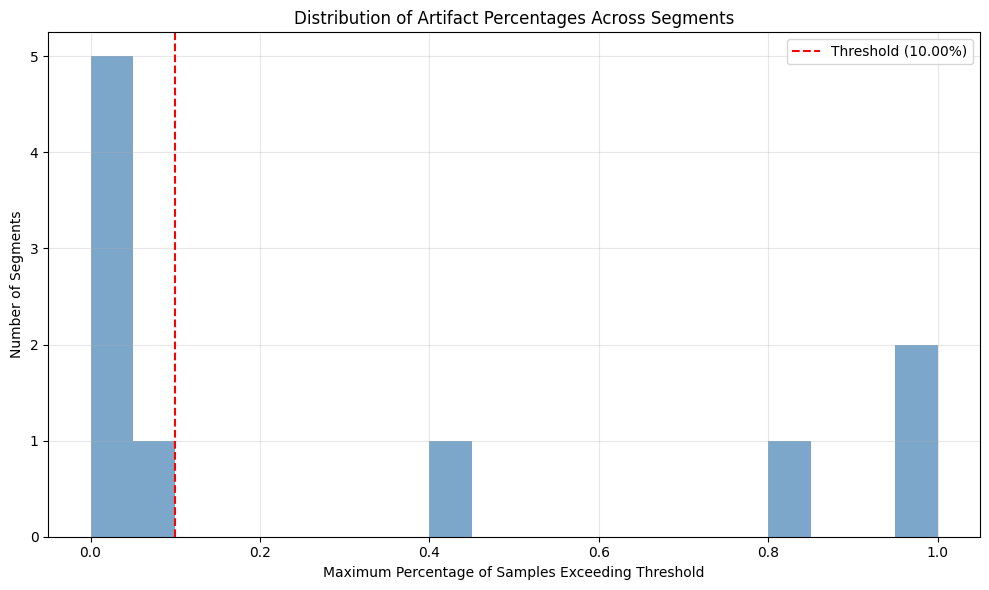

In [10]:

import os
import matplotlib.pyplot as plt

# Paths to your previously created segmented data files
input_folder = "selected_common64_channels"
output_folder = "clean_64ch_segments"
os.makedirs(output_folder, exist_ok=True)

# First, analyze the data distribution to set appropriate thresholds
print("⏳ Analyzing EEG amplitude distribution...")
all_segment_values = []
file_count = 0

# Sample a subset of files to understand the amplitude distribution
for file in sorted(os.listdir(input_folder)):
    if file.endswith("_64ch.npy"):
        file_path = os.path.join(input_folder, file)
        eeg_segment = np.load(file_path)  # Shape: (64, samples)

        # Sample 1000 random values from this segment to avoid memory issues
        sample_indices = np.random.choice(eeg_segment.size, size=1000, replace=False)
        sampled_values = eeg_segment.flatten()[sample_indices]
        all_segment_values.extend(sampled_values)

        file_count += 1
        if file_count >= 10:  # Sample from at most 10 files for speed
            break

# Calculate robust statistics for the amplitude distribution
all_segment_values = np.array(all_segment_values)
median_value = np.median(all_segment_values)
mad = np.median(np.abs(all_segment_values - median_value))  # Median Absolute Deviation
q1, q3 = np.percentile(np.abs(all_segment_values), [25, 75])
iqr = q3 - q1

# Set thresholds based on the data distribution
# Using median ± 5*MAD as a robust threshold (adjust multiplier as needed)
amplitude_threshold = median_value + 5 * mad
# Or using IQR method: Q3 + 1.5*IQR (standard outlier detection)
# amplitude_threshold = q3 + 1.5 * iqr

# Alternatively, set threshold based on percentile of the data
percentile_threshold = np.percentile(np.abs(all_segment_values), 99.5)  # 99.5th percentile

# Choose the most appropriate threshold method
amplitude_threshold = percentile_threshold  # Using percentile-based threshold

# Set how much of the segment can exceed threshold (adjust as needed)
percent_threshold = 0.10  # 10% of samples can exceed the threshold

print(f"📊 Data distribution analysis:")
print(f"  - Median amplitude: {median_value:.2f} µV")
print(f"  - MAD: {mad:.2f} µV")
print(f"  - Q1/Q3: {q1:.2f}/{q3:.2f} µV")
print(f"  - Selected amplitude threshold: {amplitude_threshold:.2f} µV")
print(f"  - Percent threshold: {percent_threshold:.2%}")

# Keep track of excluded segments
excluded_segments = []
kept_segments = []

# Stats to track
segment_stats = {}

# Process all segmented files
print("\n⏳ Applying threshold epoch selection...")
for file in sorted(os.listdir(input_folder)):
    if file.endswith("_64ch.npy"):
        # Extract excerpt code and trial number from filename
        excerpt_info = file.split('_')
        excerpt_code = int(excerpt_info[1])
        trial_number = int(excerpt_info[3])

        # Load the 64-channel EEG segment
        file_path = os.path.join(input_folder, file)
        eeg_segment = np.load(file_path)  # Shape: (64, samples)

        # Calculate percent of samples exceeding threshold for each channel
        exceeded_samples = np.sum(np.abs(eeg_segment) > amplitude_threshold, axis=1) / eeg_segment.shape[1]
        max_exceeded_percent = np.max(exceeded_samples)
        avg_exceeded_percent = np.mean(exceeded_samples)
        worst_channel = np.argmax(exceeded_samples)

        # Store stats for this segment
        segment_stats[file] = {
            'excerpt_code': excerpt_code,
            'trial_number': trial_number,
            'max_exceeded_percent': max_exceeded_percent,
            'avg_exceeded_percent': avg_exceeded_percent,
            'worst_channel': worst_channel
        }

        # Check if the segment passes the threshold criteria
        if max_exceeded_percent <= percent_threshold:
            # Save clean segment
            out_path = os.path.join(output_folder, file)
            np.save(out_path, eeg_segment)
            kept_segments.append((excerpt_code, trial_number))
            print(f"✅ Kept: {file} (Max exceeded: {max_exceeded_percent:.2%}, Avg: {avg_exceeded_percent:.2%})")
        else:
            excluded_segments.append((excerpt_code, trial_number))
            print(f"❌ Excluded: {file} (Max exceeded: {max_exceeded_percent:.2%}, Avg: {avg_exceeded_percent:.2%})")

# Generate summary
print("\n📊 Threshold Epoch Selection Summary:")
print(f"Total segments processed: {len(kept_segments) + len(excluded_segments)}")
print(f"Segments kept: {len(kept_segments)}")
print(f"Segments excluded: {len(excluded_segments)}")
print(f"Exclusion rate: {len(excluded_segments) / (len(kept_segments) + len(excluded_segments)):.2%}")

# Plot histogram of max exceeded percentages
plt.figure(figsize=(10, 6))
max_percentages = [stats['max_exceeded_percent'] for stats in segment_stats.values()]
plt.hist(max_percentages, bins=20, color='steelblue', alpha=0.7)
plt.axvline(x=percent_threshold, color='red', linestyle='--', label=f'Threshold ({percent_threshold:.2%})')
plt.xlabel('Maximum Percentage of Samples Exceeding Threshold')
plt.ylabel('Number of Segments')
plt.title('Distribution of Artifact Percentages Across Segments')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'threshold_distribution.png'))

# Generate report by excerpt code
excerpt_stats = {}
for stats in segment_stats.values():
    code = stats['excerpt_code']
    if code not in excerpt_stats:
        excerpt_stats[code] = {'total': 0, 'kept': 0, 'excluded': 0}
    excerpt_stats[code]['total'] += 1
    if (code, stats['trial_number']) in kept_segments:
        excerpt_stats[code]['kept'] += 1
    else:
        excerpt_stats[code]['excluded'] += 1

print("\n📊 Results by Excerpt Code:")
print("Excerpt Code | Total | Kept | Excluded | Exclusion Rate")
print("-" * 60)
for code in sorted(excerpt_stats.keys()):
    stats = excerpt_stats[code]
    exclusion_rate = stats['excluded'] / stats['total'] if stats['total'] > 0 else 0
    print(f"{code:12} | {stats['total']:5} | {stats['kept']:4} | {stats['excluded']:8} | {exclusion_rate:.2%}")

# Save the clean excerpt information
with open(os.path.join(output_folder, 'clean_excerpts_info.txt'), 'w') as f:
    f.write("Excerpt_Code,Trial_Number\n")
    for code, trial in sorted(kept_segments):
        f.write(f"{code},{trial}\n")

print("\n✅ Threshold epoch selection complete. Results saved to clean_64ch_segments folder.")

In [11]:
import os
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt

# === Settings ===
input_folder = "clean_64ch_segments"
output_folder = "bandpass_filtered_segments"
os.makedirs(output_folder, exist_ok=True)

# Load sampling rate
Fs = int(scipy.io.loadmat(file_path_2, simplify_cells=True)['Fs'])

# Design Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

b, a = butter_bandpass(1, 40, Fs)  # 1–40 Hz bandpass filter

print("⏳ Applying bandpass filter (1–40 Hz)...")

# Process each clean EEG segment
for file in sorted(os.listdir(input_folder)):
    if file.endswith(".npy"):
        file_path = os.path.join(input_folder, file)
        eeg = np.load(file_path)  # Shape: (64, N)

        # Apply filter channel-wise
        filtered_eeg = np.array([filtfilt(b, a, ch) for ch in eeg])

        # Save filtered segment
        out_path = os.path.join(output_folder, file.replace(".npy", "_filt.npy"))
        np.save(out_path, filtered_eeg)

        print(f"✅ Filtered & saved: {os.path.basename(out_path)}")

print("\n🎉 Bandpass filtering complete! Filtered segments saved in:", output_folder)

⏳ Applying bandpass filter (1–40 Hz)...
✅ Filtered & saved: excerpt_21_trial_1_64ch_filt.npy
✅ Filtered & saved: excerpt_21_trial_2_64ch_filt.npy
✅ Filtered & saved: excerpt_26_trial_1_64ch_filt.npy
✅ Filtered & saved: excerpt_28_trial_1_64ch_filt.npy
✅ Filtered & saved: excerpt_33_trial_1_64ch_filt.npy
✅ Filtered & saved: excerpt_36_trial_1_64ch_filt.npy

🎉 Bandpass filtering complete! Filtered segments saved in: bandpass_filtered_segments


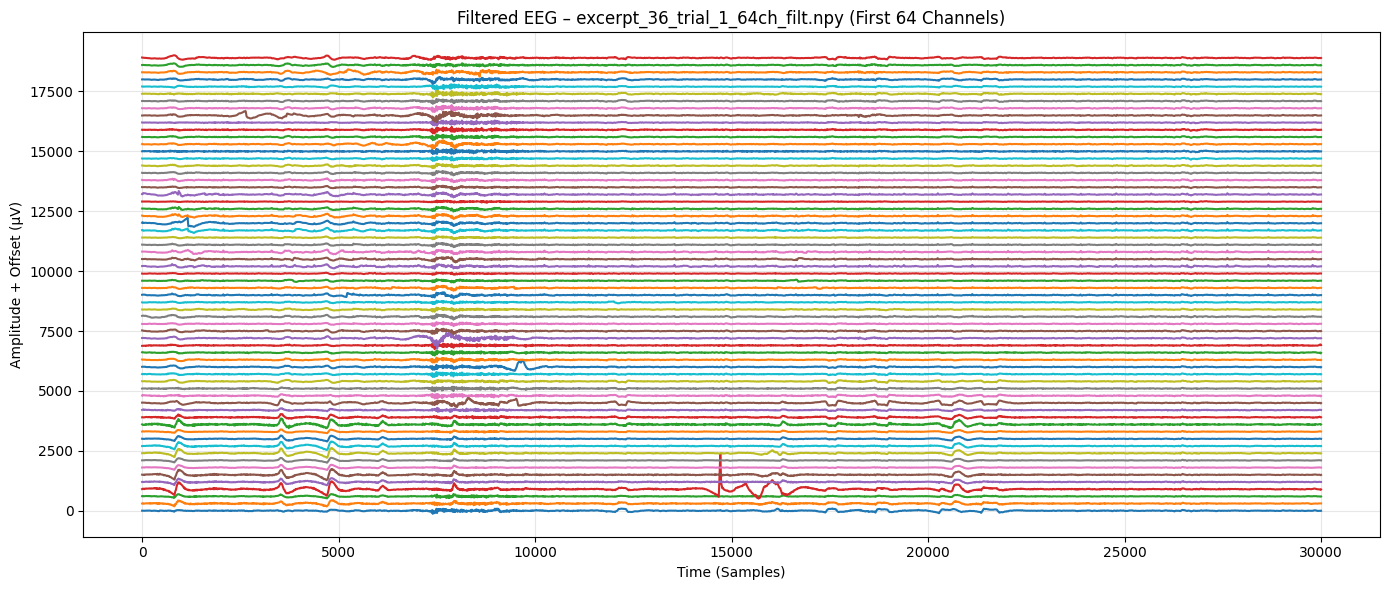

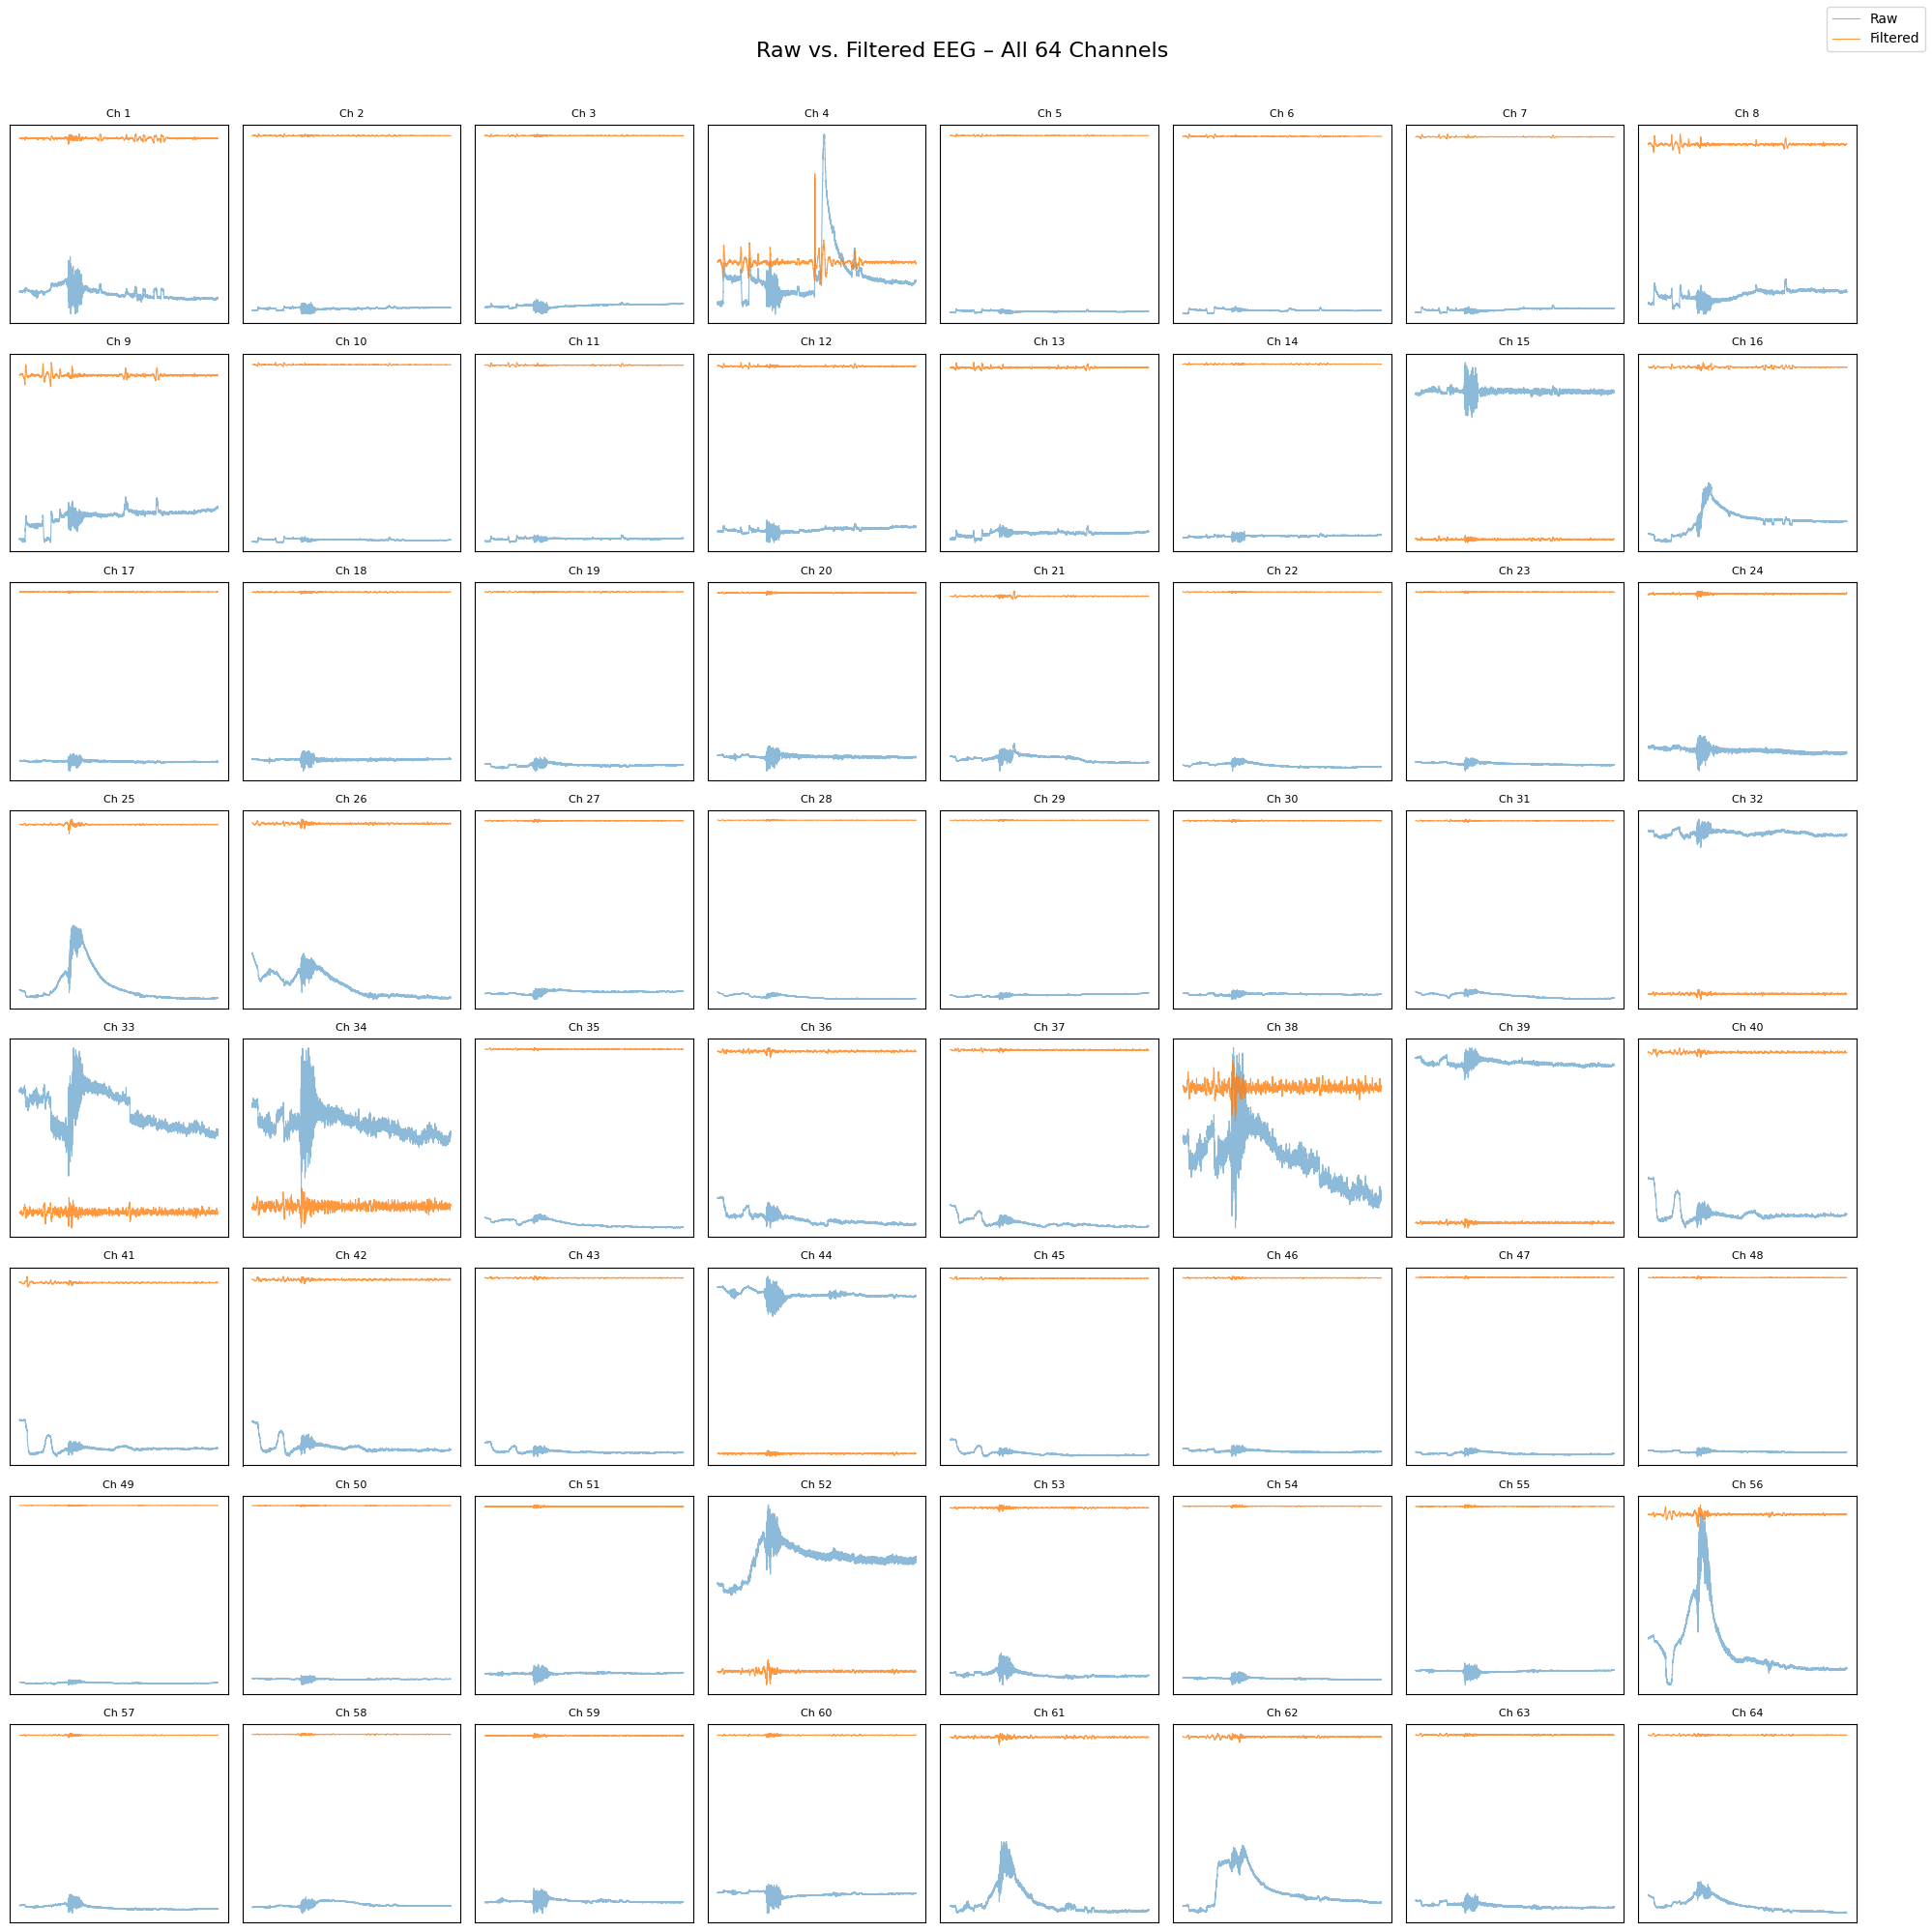


📊 Summary of Filtered EEG Segments:

excerpt_21_trial_1_64ch_filt.npy: Mean = 0.02 µV, Std = 26.62 µV
excerpt_21_trial_2_64ch_filt.npy: Mean = 0.00 µV, Std = 19.59 µV
excerpt_26_trial_1_64ch_filt.npy: Mean = -0.03 µV, Std = 13.57 µV
excerpt_28_trial_1_64ch_filt.npy: Mean = -0.01 µV, Std = 15.36 µV
excerpt_33_trial_1_64ch_filt.npy: Mean = -0.01 µV, Std = 12.75 µV
excerpt_36_trial_1_64ch_filt.npy: Mean = -0.00 µV, Std = 20.92 µV

✅ All visualizations saved in: filter_visualizations


In [13]:

# Folders
filtered_folder = "bandpass_filtered_segments"
raw_folder = "clean_64ch_segments"
output_plot_folder = "filter_visualizations"
os.makedirs(output_plot_folder, exist_ok=True)

# Load one sample filtered file
filtered_files = sorted([f for f in os.listdir(filtered_folder) if f.endswith(".npy")])
example_file = filtered_files[5]
filtered_path = os.path.join(filtered_folder, example_file)
eeg_filtered = np.load(filtered_path)

# Load corresponding raw segment
raw_path = os.path.join(raw_folder, example_file.replace("_filt.npy", ".npy"))
eeg_raw = np.load(raw_path)

# === Plot 1: Stacked plot of first 10 channels ===
plt.figure(figsize=(14, 6))
offset = 300
for ch in range(64):
    plt.plot(eeg_filtered[ch] + ch * offset, label=f"Ch {ch+1}")
plt.title(f"Filtered EEG – {example_file} (First 64 Channels)")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude + Offset (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_plot_folder, "stacked_channels.png"))
plt.show()

# === Plot 2:  All Channel  - Raw vs. Filtered ===
fig, axs = plt.subplots(8, 8, figsize=(20, 20))  # 8x8 grid for 64 channels
fig.suptitle("Raw vs. Filtered EEG – All 64 Channels", fontsize=16)

for ch in range(64):
    ax = axs[ch // 8, ch % 8]
    ax.plot(eeg_raw[ch], label="Raw", alpha=0.5, linewidth=0.8)
    ax.plot(eeg_filtered[ch], label="Filtered", alpha=0.8, linewidth=0.8)
    ax.set_title(f"Ch {ch+1}", fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=6)
    ax.set_xticks([])
    ax.set_yticks([])

# Add one legend outside the grid
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.97, 0.97])  # Adjust for suptitle and legend
plt.savefig(os.path.join(output_plot_folder, "all_channels_raw_vs_filtered.png"))
plt.show()

# === Plot 3: Heatmap of EEG (First 20 channels) ===
# plt.figure(figsize=(14, 6))
# sns.heatmap(eeg_filtered[:20], cmap='viridis', cbar_kws={'label': 'Amplitude (µV)'})
# plt.title("EEG Heatmap (First 20 Channels × Time)")
# plt.xlabel("Time (Samples)")
# plt.ylabel("Channel")
# plt.tight_layout()
# plt.savefig(os.path.join(output_plot_folder, "heatmap_filtered.png"))
# plt.show()

# === Print summary statistics ===
print("\n📊 Summary of Filtered EEG Segments:\n")
for file in filtered_files:
    eeg = np.load(os.path.join(filtered_folder, file))
    mean_amp = np.mean(eeg)
    std_amp = np.std(eeg)
    print(f"{file}: Mean = {mean_amp:.2f} µV, Std = {std_amp:.2f} µV")

print("\n✅ All visualizations saved in:", output_plot_folder)

In [ ]:
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters ===
Fs = 128
channel_names = [f"Ch{i+1}" for i in range(64)]
channel_types = ["eeg"] * 64

# === Folders ===
filtered_folder = "bandpass_filtered_segments"
ica_output_folder = "ica_applied_segments"
os.makedirs(ica_output_folder, exist_ok=True)

# === Load All Filtered Files ===
filtered_files = sorted([f for f in os.listdir(filtered_folder) if f.endswith("_filt.npy")])

for file in filtered_files:
    print(f"\n🔄 Processing: {file}")

    # Load filtered segment
    eeg_data = np.load(os.path.join(filtered_folder, file))  # Shape: (64, samples)

    # Create MNE Raw object
    info = mne.create_info(ch_names=channel_names, sfreq=Fs, ch_types=channel_types)
    raw = mne.io.RawArray(eeg_data, info)
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()  # Apply the average reference

    # ✅ High-pass filter at 1.0 Hz to improve ICA performance
    raw.filter(l_freq=1.0, h_freq=None)

    # ICA fitting
    ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter='auto')
    ica.fit(raw)

    # Plot ICA component time series
    ica_sources = ica.get_sources(raw)
    fig = ica_sources.plot(n_channels=10, title=f"ICA Sources – {file}", show=False)
    fig.savefig(os.path.join(ica_output_folder, file.replace(".npy", "_ica_sources.png")))

    # Apply ICA
    raw_clean = ica.apply(raw.copy())
    cleaned_data = raw_clean.get_data()

    # Save cleaned data
    output_file = os.path.join(ica_output_folder, file.replace("_filt.npy", "_ica.npy"))
    np.save(output_file, cleaned_data)

    print(f"✅ ICA-cleaned EEG saved to: {output_file}")

# === Visualization Subplots ===
# Load a sample original and cleaned file for comparison
sample_file = filtered_files[0]
raw_data = np.load(os.path.join(filtered_folder, sample_file))
cleaned_data = np.load(os.path.join(ica_output_folder, sample_file.replace("_filt.npy", "_ica.npy")))

# # Plot subplots
# fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# fig.suptitle("EEG ICA Cleaning Visualization", fontsize=16)

# # Plot 1: Original EEG - Channel 1
# axs[0, 0].plot(raw_data[0], color='gray')
# axs[0, 0].set_title("Original EEG – Channel 1")
# axs[0, 0].set_xlabel("Time (samples)")
# axs[0, 0].set_ylabel("Amplitude (µV)")
# axs[0, 0].grid(True)

# # Plot 2: ICA Cleaned EEG - Channel 1
# axs[0, 1].plot(cleaned_data[0], color='green')
# axs[0, 1].set_title("ICA-Cleaned EEG – Channel 1")
# axs[0, 1].set_xlabel("Time (samples)")
# axs[0, 1].set_ylabel("Amplitude (µV)")
# axs[0, 1].grid(True)

# # Plot 3: Overlaid comparison
# axs[1, 0].plot(raw_data[0], label='Original', alpha=0.5)
# axs[1, 0].plot(cleaned_data[0], label='Cleaned', alpha=0.8)
# axs[1, 0].set_title("Overlay: Original vs Cleaned – Channel 1")
# axs[1, 0].set_xlabel("Time (samples)")
# axs[1, 0].set_ylabel("Amplitude (µV)")
# axs[1, 0].legend()
# axs[1, 0].grid(True)

# # Plot 4: Heatmap of cleaned EEG (all channels)
# sns.heatmap(cleaned_data, ax=axs[1, 1], cmap='viridis', cbar_kws={'label': 'Amplitude (µV)'})
# axs[1, 1].set_title("ICA-Cleaned EEG Heatmap (64 Channels × Time)")
# axs[1, 1].set_xlabel("Time (samples)")
# axs[1, 1].set_ylabel("Channel")

# plt.tight_layout(rect=[0, 0, 1, 0.96])  # space for title
# plt.show()


Processing EEG Files:   0%|          | 0/6 [00:00<?, ?it/s]


🔄 Processing: excerpt_21_trial_1_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_21_trial_1_64ch_ica.npy

Processing EEG Files:  17%|█▋        | 1/6 [00:03<00:16,  3.30s/it]


✅ ICA components saved to: ica_applied_segments\excerpt_21_trial_1_64ch_ica_components.npy

🔄 Processing: excerpt_21_trial_2_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_21_trial_2_64ch_ica.npy

Processing EEG Files:  33%|███▎      | 2/6 [00:05<00:10,  2.56s/it]


✅ ICA components saved to: ica_applied_segments\excerpt_21_trial_2_64ch_ica_components.npy

🔄 Processing: excerpt_26_trial_1_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 24.9s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)


c:\Users\Krishnansh Verma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


Processing EEG Files:  50%|█████     | 3/6 [00:30<00:39, 13.02s/it]

✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_26_trial_1_64ch_ica.npy
✅ ICA components saved to: ica_applied_segments\excerpt_26_trial_1_64ch_ica_components.npy

🔄 Processing: excerpt_28_trial_1_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


Processing EEG Files:  67%|██████▋   | 4/6 [00:33<00:17,  8.97s/it]

✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_28_trial_1_64ch_ica.npy
✅ ICA components saved to: ica_applied_segments\excerpt_28_trial_1_64ch_ica_components.npy

🔄 Processing: excerpt_33_trial_1_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 26.3s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


c:\Users\Krishnansh Verma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Processing EEG Files:  83%|████████▎ | 5/6 [01:00<00:15, 15.39s/it]

✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_33_trial_1_64ch_ica.npy
✅ ICA components saved to: ica_applied_segments\excerpt_33_trial_1_64ch_ica_components.npy

🔄 Processing: excerpt_36_trial_1_64ch_filt.npy
Creating RawArray with float64 data, n_channels=64, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   234.367 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.9s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


Processing EEG Files: 100%|██████████| 6/6 [01:03<00:00, 10.62s/it]

✅ ICA-cleaned EEG saved to: ica_applied_segments\excerpt_36_trial_1_64ch_ica.npy
✅ ICA components saved to: ica_applied_segments\excerpt_36_trial_1_64ch_ica_components.npy


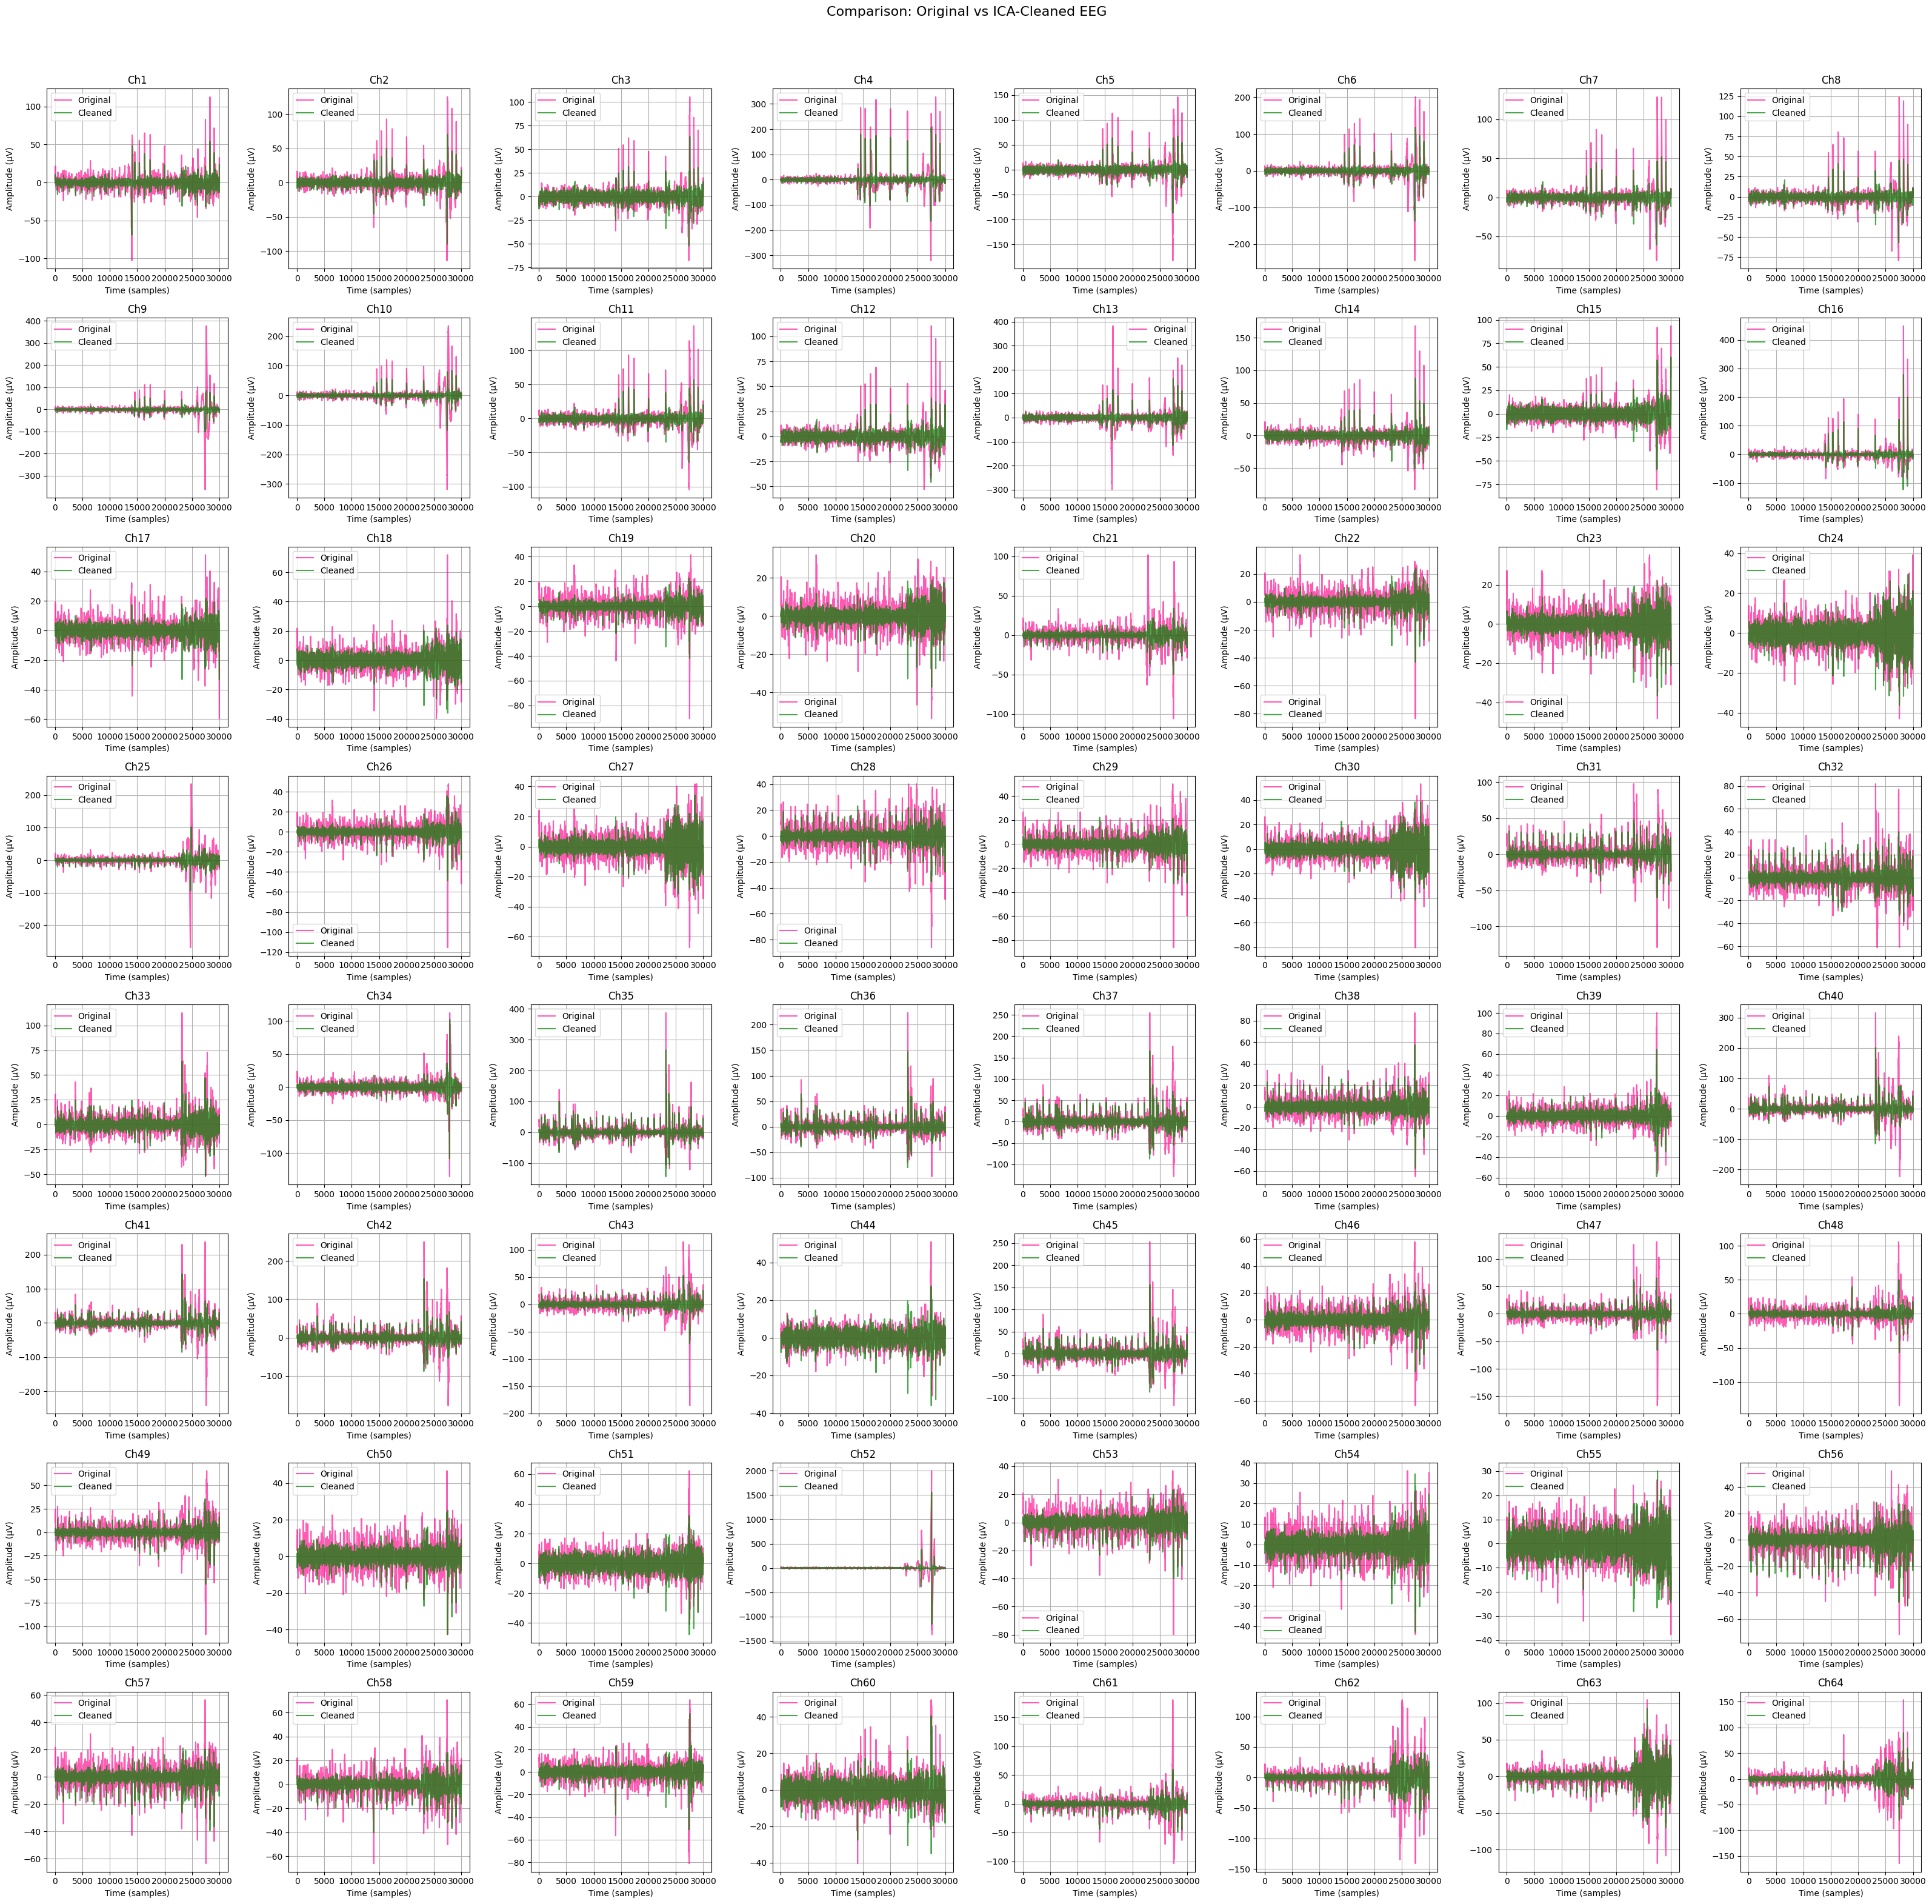

In [33]:
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar

# === Parameters ===
Fs = 128
channel_names = [f"Ch{i+1}" for i in range(64)]
channel_types = ["eeg"] * 64

# === Folders ===
filtered_folder = "bandpass_filtered_segments"
ica_output_folder = "ica_applied_segments"
os.makedirs(ica_output_folder, exist_ok=True)

# === Load All Filtered Files ===
filtered_files = sorted([f for f in os.listdir(filtered_folder) if f.endswith("_filt.npy")])

# === Process Each Filtered File with a Progress Bar ===
for file in tqdm(filtered_files, desc="Processing EEG Files"):

    print(f"\n🔄 Processing: {file}")

    # Load filtered segment
    eeg_data = np.load(os.path.join(filtered_folder, file))  # Shape: (64, samples)

    # Create MNE Raw object
    info = mne.create_info(ch_names=channel_names, sfreq=Fs, ch_types=channel_types)
    raw = mne.io.RawArray(eeg_data, info)
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()  # Apply the average reference

    # ✅ High-pass filter at 1.0 Hz to improve ICA performance
    raw.filter(l_freq=1.0, h_freq=None)

    # ICA fitting with adjusted parameters (handling convergence warning)
    ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter=800)
    ica.fit(raw)

    # Apply ICA
    raw_clean = ica.apply(raw.copy())
    cleaned_data = raw_clean.get_data()

    # Save cleaned data
    output_file = os.path.join(ica_output_folder, file.replace("_filt.npy", "_ica.npy"))
    np.save(output_file, cleaned_data)

    # Save ICA components
    ica_components = ica.get_components()
    ica_components_file = os.path.join(ica_output_folder, file.replace("_filt.npy", "_ica_components.npy"))
    np.save(ica_components_file, ica_components)

    print(f"✅ ICA-cleaned EEG saved to: {output_file}")
    print(f"✅ ICA components saved to: {ica_components_file}")

# === Visualization of Comparison for All 64 Channels in One Graph ===
# Load a sample original and cleaned file for comparison
sample_file = filtered_files[0]
raw_data = np.load(os.path.join(filtered_folder, sample_file))
cleaned_data = np.load(os.path.join(ica_output_folder, sample_file.replace("_filt.npy", "_ica.npy")))

# Create a figure for the comparison (Original vs ICA-Cleaned)
fig, axs = plt.subplots(8, 8, figsize=(32, 32))  # 8x8 grid for 64 channels
fig.suptitle("Comparison: Original vs ICA-Cleaned EEG", fontsize=16)

for i in range(64):  # Loop through all 64 channels
    # Original EEG (gray)
    axs[i // 8, i % 8].plot(raw_data[i], label='Original', color='deeppink', alpha=0.7)
    
    # ICA-cleaned EEG (green)
    axs[i // 8, i % 8].plot(cleaned_data[i], label='Cleaned', color='green', alpha=0.7)
    
    axs[i // 8, i % 8].set_title(f"Ch{i+1}")
    axs[i // 8, i % 8].set_xlabel("Time (samples)")
    axs[i // 8, i % 8].set_ylabel("Amplitude (µV)")
    axs[i // 8, i % 8].legend()
    axs[i // 8, i % 8].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # space for title
plt.show()
